# Gymnasium env

In [3]:
import gymnasium as gym
from gymnasium import spaces
import cv2
from typing import Tuple, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from PIL import Image
import numpy as np


%matplotlib inline
plt.style.use(['dark_background', 'seaborn-v0_8'])

In [4]:
class TicTacToeEnv(gym.Env):
    """
    Tic-Tac-Toe environment following Gymnasium API.
    - Agent plays as X (1)
    - Opponent plays as O (-1)
    - Empty = 0
    - Action space: Discrete(9) → cell index (0 to 8)
    - Observation space: Box(-1, 1, (3, 3), dtype=int)
    """

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 1}

    def __init__(self, render_mode=None):
        self.render_mode = render_mode
        self.board = np.zeros((3, 3), dtype=int)
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(3, 3), dtype=int)

        self.window = None
        self.clock = None

    def _check_winner(self, board) -> int:
        """Check if there's a winner. Return 1 (X), -1 (O), or 0 (no winner)."""
        # Check rows and cols
        for i in range(3):
            if abs(board[i, :].sum()) == 3:
                return board[i, 0]
            if abs(board[:, i].sum()) == 3:
                return board[0, i]
        # Diagonals
        if abs(board[0, 0] + board[1, 1] + board[2, 2]) == 3:
            return board[1, 1]
        if abs(board[0, 2] + board[1, 1] + board[2, 0]) == 3:
            return board[1, 1]
        return 0

    def _is_board_full(self) -> bool:
        return not (self.board == 0).any()

    def reset(self, seed=None, options=None) -> Tuple[np.ndarray, Dict]:
        super().reset(seed=seed)
        self.board = np.zeros((3, 3), dtype=int)
        if self.render_mode == "human":
            self._render_frame()
        return self.board.copy(), {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """
        Agent (X) takes an action.
        Then opponent (O) takes a move (we'll handle opponent OUTSIDE env for flexibility).
        BUT: for simplicity in basic usage, we'll assume opponent move is handled externally.
        So this env ONLY handles agent's move.

        Important: In standard RL, env should include opponent.
        So we'll modify: after agent moves, if game not over, opponent auto-moves (random for now).
        """
        # Convert action to row/col
        row, col = divmod(action, 3)

        # Validate action
        if self.board[row, col] != 0:
            # Invalid move: big penalty and episode ends
            reward = -10.0
            terminated = True
            truncated = False
            observation = self.board.copy()
            if self.render_mode == "human":
                self._render_frame()
            return observation, reward, terminated, truncated, {}

        # Agent (X) move
        self.board[row, col] = 1

        # Check if agent won
        winner = self._check_winner(self.board)
        if winner == 1:
            reward = 1.0
            terminated = True
            truncated = False
            observation = self.board.copy()
            if self.render_mode == "human":
                self._render_frame()
            return observation, reward, terminated, truncated, {}

        if self._is_board_full():
            reward = 0.0
            terminated = True
            truncated = False
            observation = self.board.copy()
            if self.render_mode == "human":
                self._render_frame()
            return observation, reward, terminated, truncated, {}

        # Opponent (O) move — simple random for now
        valid_moves = np.argwhere(self.board == 0)
        if len(valid_moves) == 0:
            # Should not happen if checked above
            reward = 0.0
            terminated = True
            truncated = False
            observation = self.board.copy()
            if self.render_mode == "human":
                self._render_frame()
            return observation, reward, terminated, truncated, {}

        # Random opponent
        opp_move = valid_moves[np.random.choice(len(valid_moves))]
        self.board[opp_move[0], opp_move[1]] = -1

        # Check if opponent won
        winner = self._check_winner(self.board)
        if winner == -1:
            reward = -1.0
            terminated = True
        elif self._is_board_full():
            reward = 0.0
            terminated = True
        else:
            reward = 0.0
            terminated = False

        truncated = False
        observation = self.board.copy()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, truncated, {}

    def _render_frame(self):
        if self.render_mode == "human":
            if self.window is None:
                cv2.namedWindow("Tic-Tac-Toe", cv2.WINDOW_AUTOSIZE)
            # Create image
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
            # Draw grid
            cv2.line(img, (100, 0), (100, 300), (0, 0, 0), 3)
            cv2.line(img, (200, 0), (200, 300), (0, 0, 0), 3)
            cv2.line(img, (0, 100), (300, 100), (0, 0, 0), 3)
            cv2.line(img, (0, 200), (300, 200), (0, 0, 0), 3)

            # Draw X and O
            for i in range(3):
                for j in range(3):
                    center = (j * 100 + 50, i * 100 + 50)
                    if self.board[i, j] == 1:  # X
                        cv2.line(img, (j * 100 + 20, i * 100 + 20), (j * 100 + 80, i * 100 + 80), (0, 0, 255), 5)
                        cv2.line(img, (j * 100 + 80, i * 100 + 20), (j * 100 + 20, i * 100 + 80), (0, 0, 255), 5)
                    elif self.board[i, j] == -1:  # O
                        cv2.circle(img, center, 30, (255, 0, 0), 5)

            cv2.imshow("Tic-Tac-Toe", img)
            cv2.waitKey(100)  # Pause briefly

    def render(self):
        if self.render_mode == "rgb_array":
            # Return RGB image array (for logging)
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
            cv2.line(img, (100, 0), (100, 300), (0, 0, 0), 3)
            cv2.line(img, (200, 0), (200, 300), (0, 0, 0), 3)
            cv2.line(img, (0, 100), (300, 100), (0, 0, 0), 3)
            cv2.line(img, (0, 200), (300, 200), (0, 0, 0), 3)
            for i in range(3):
                for j in range(3):
                    center = (j * 100 + 50, i * 100 + 50)
                    if self.board[i, j] == 1:
                        cv2.line(img, (j * 100 + 20, i * 100 + 20), (j * 100 + 80, i * 100 + 80), (0, 0, 255), 5)
                        cv2.line(img, (j * 100 + 80, i * 100 + 20), (j * 100 + 20, i * 100 + 80), (0, 0, 255), 5)
                    elif self.board[i, j] == -1:
                        cv2.circle(img, center, 30, (255, 0, 0), 5)
            return img
        elif self.render_mode == "human":
            self._render_frame()

    def close(self):
        if self.window is not None:
            cv2.destroyAllWindows()
            self.window = None

In [5]:
# env = TicTacToeEnv(render_mode="human")  # Try "rgb_array" or None too
#
# obs, _ = env.reset()
# done = False
#
# while not done:
#     valid_actions = np.argwhere(obs == 0).flatten()
#     if len(valid_actions) == 0:
#         break
#     action = np.random.choice(valid_actions)
#     obs, reward, terminated, truncated, info = env.step(action)
#     done = terminated or truncated
#     print(f"Action: {action}, Reward: {reward}, Done: {done}")
#     print(obs)
#
# env.close()

# DQN

In [6]:
class QNetwork(nn.Module):
    def __init__(self, state_dim=9, action_dim=9, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(start_dim=1),  # Handles [B,3,3] → [B,9]
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.net(x)

In [7]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # Convert to numpy if needed (for uniform storage)
        state = np.array(state, dtype=np.float32)
        next_state = np.array(next_state, dtype=np.float32)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return (
            torch.tensor(state),
            torch.tensor(action).long(),
            torch.tensor(reward).float(),
            torch.tensor(next_state),
            torch.tensor(done).bool()
        )

    def __len__(self):
        return len(self.buffer)

In [8]:
class DQNAgent:
    def __init__(self, state_dim=9, action_dim=9, lr=1e-3, gamma=0.99, epsilon_start=1.0, epsilon_min=0.01,
                 epsilon_decay=0.995):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.action_dim = action_dim
        self.update_target()

    def update_target(self):
        """Copy weights from q_net to target_net"""
        self.target_net.load_state_dict(self.q_net.state_dict())

    def act(self, state, valid_actions_mask):
        """
        Choose action using ε-greedy.
        valid_actions_mask: boolean array of shape (9,) — True if valid
        """
        # Ensure state is tensor and on device
        if isinstance(state, np.ndarray):
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        elif torch.is_tensor(state):
            state = state.unsqueeze(0).to(self.device)

        if random.random() <= self.epsilon:
            # Random valid action
            valid_indices = np.where(valid_actions_mask)[0]
            return np.random.choice(valid_indices)
        else:
            # Greedy: choose best valid action
            q_values = self.q_net(state)  # [1, 9]
            q_values = q_values.squeeze(0).cpu().detach().numpy()
            # Mask invalid actions with -inf
            masked_q = np.where(valid_actions_mask, q_values, -1e9)
            return np.argmax(masked_q)

    def learn(self, states, actions, rewards, next_states, dones, batch_size):
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        # Current Q (only for taken actions)
        current_q = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Compute target Q with masking
        with torch.no_grad():
            next_q_all = self.target_net(next_states)  # [B, 9]
            # Create mask for valid actions in next state
            valid_mask = get_valid_action_mask_batch(next_states).to(self.device)  # [B, 9]
            # Mask invalid actions with large negative number
            next_q_all_masked = next_q_all.masked_fill(~valid_mask, -1e9)
            # Take max over ONLY valid actions
            next_q = next_q_all_masked.max(1)[0]  # [B]
            target_q = rewards + (self.gamma * next_q * (~dones))

        loss = F.mse_loss(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

In [9]:
def get_valid_action_mask_batch(states: torch.Tensor) -> torch.Tensor:
    """
    states: [B, 3, 3] or [B, 9]
    Returns: [B, 9] boolean tensor — True if action is valid
    """
    if states.dim() == 3:
        flat = states.flatten(start_dim=1)  # [B, 9]
    else:
        flat = states
    return (flat == 0)  # empty cells are valid


def get_valid_actions_mask(board):
    """Return boolean mask of valid (empty) cells. Shape: (9,)"""
    flat = board.flatten()
    return (flat == 0)


def evaluate_agent(agent, episodes=100):
    """Evaluate win rate against random opponent (no training)"""
    # env = TicTacToeEnv(render_mode="human")
    env = TicTacToeEnv()
    wins = 0
    draws = 0
    losses = 0
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            mask = get_valid_actions_mask(obs)
            action = agent.act(obs, mask)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        if reward == 1:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1
    env.close()
    return wins / episodes, draws / episodes, losses / episodes

## Training loop

In [10]:
# env = TicTacToeEnv(render_mode="human")
env = TicTacToeEnv()
agent = DQNAgent()
replay_buffer = ReplayBuffer(capacity=10000)

BATCH_SIZE = 64
TARGET_UPDATE_FREQ = 100
EVAL_FREQ = 500
TOTAL_STEPS = 20000

losses = []
win_rates = []
step_count = 0

In [11]:
for episode in range(10_000):
    obs, _ = env.reset()
    done = False

    while not done:
        mask = get_valid_actions_mask(obs)
        action = agent.act(obs, mask)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        replay_buffer.push(obs, action, reward, next_obs, done)
        obs = next_obs
        step_count += 1

        # Train if enough samples
        if len(replay_buffer) > BATCH_SIZE:
            states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)
            loss = agent.learn(states, actions, rewards, next_states, dones, BATCH_SIZE)
            losses.append(loss)

        # Update target network
        if step_count % TARGET_UPDATE_FREQ == 0:
            agent.update_target()

        # Evaluate periodically
        if step_count % EVAL_FREQ == 0:
            win_rate, draw_rate, loss_rate = evaluate_agent(agent, episodes=200)
            win_rates.append(win_rate)
            print(f"Step {step_count}: x`Win Rate = {win_rate:.2%}, ε = {agent.epsilon:.3f}")

        if step_count >= TOTAL_STEPS:
            break
    if step_count >= TOTAL_STEPS:
        break

Step 500: x`Win Rate = 84.50%, ε = 0.112
Step 1000: x`Win Rate = 90.00%, ε = 0.010
Step 1500: x`Win Rate = 89.50%, ε = 0.010
Step 2000: x`Win Rate = 89.00%, ε = 0.010
Step 2500: x`Win Rate = 87.50%, ε = 0.010
Step 3000: x`Win Rate = 88.00%, ε = 0.010
Step 3500: x`Win Rate = 84.50%, ε = 0.010
Step 4000: x`Win Rate = 97.00%, ε = 0.010
Step 4500: x`Win Rate = 94.00%, ε = 0.010
Step 5000: x`Win Rate = 95.50%, ε = 0.010
Step 5500: x`Win Rate = 87.00%, ε = 0.010
Step 6000: x`Win Rate = 96.50%, ε = 0.010
Step 6500: x`Win Rate = 95.50%, ε = 0.010
Step 7000: x`Win Rate = 98.00%, ε = 0.010
Step 7500: x`Win Rate = 96.00%, ε = 0.010
Step 8000: x`Win Rate = 91.50%, ε = 0.010
Step 8500: x`Win Rate = 88.50%, ε = 0.010
Step 9000: x`Win Rate = 98.00%, ε = 0.010
Step 9500: x`Win Rate = 92.00%, ε = 0.010
Step 10000: x`Win Rate = 98.50%, ε = 0.010
Step 10500: x`Win Rate = 94.00%, ε = 0.010
Step 11000: x`Win Rate = 98.00%, ε = 0.010
Step 11500: x`Win Rate = 96.50%, ε = 0.010
Step 12000: x`Win Rate = 97.00%

In [53]:
# env.close()

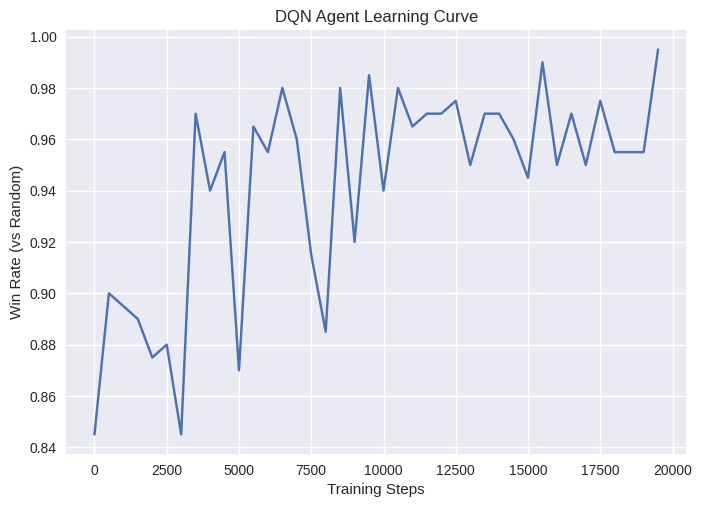

In [12]:
plt.plot(np.arange(len(win_rates)) * EVAL_FREQ, win_rates)
plt.xlabel("Training Steps")
plt.ylabel("Win Rate (vs Random)")
plt.title("DQN Agent Learning Curve")
plt.grid(True)
plt.show()

In [13]:
torch.save(agent.q_net.state_dict(), "models/dqn_tictactoe-v0.pth")

## Making the bot play 2nd even though it was trained to make 1st move (O=1, X=-1) -> (O=-1, X=1)

In [21]:
class TicTacToeEnvV2(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 1}

    def __init__(self, render_mode=None, agent_is_x=True):
        self.render_mode = render_mode
        self.agent_is_x = agent_is_x
        self.board = np.zeros((3, 3), dtype=int)  # Internally: X=1, O=-1
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(3, 3), dtype=int)
        self.window = None

    def _check_winner(self, board) -> int:
        """Check winner on internal board (X=1, O=-1). Return 1, -1, or 0."""
        for i in range(3):
            if abs(board[i, :].sum()) == 3:
                return board[i, 0]
            if abs(board[:, i].sum()) == 3:
                return board[0, i]
        if abs(board[0, 0] + board[1, 1] + board[2, 2]) == 3:
            return board[1, 1]
        if abs(board[0, 2] + board[1, 1] + board[2, 0]) == 3:
            return board[1, 1]
        return 0

    def _is_board_full(self) -> bool:
        return not (self.board == 0).any()

    def _get_obs(self) -> np.ndarray:
        """Return observation from agent's perspective."""
        if self.agent_is_x:
            return self.board.copy()  # X=+1 (agent), O=-1 (opponent)
        else:
            return -self.board.copy()  # O becomes +1 (agent), X becomes -1 (opponent)

    def reset(self, seed=None, options=None) -> Tuple[np.ndarray, Dict]:
        super().reset(seed=seed)
        self.board = np.zeros((3, 3), dtype=int)
        if self.render_mode == "human":
            self._render_frame()
        return self._get_obs(), {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        row, col = divmod(action, 3)

        # Validate action on true board
        if self.board[row, col] != 0:
            obs = self._get_obs()
            if self.render_mode == "human":
                self._render_frame()
            return obs, -10.0, True, False, {}

        # Agent places its piece (using internal symbol)
        agent_symbol = 1 if self.agent_is_x else -1
        self.board[row, col] = agent_symbol

        # Check immediate win/draw
        winner = self._check_winner(self.board)
        if winner == agent_symbol:
            obs = self._get_obs()
            if self.render_mode == "human":
                self._render_frame()
            return obs, 1.0, True, False, {}
        if self._is_board_full():
            obs = self._get_obs()
            if self.render_mode == "human":
                self._render_frame()
            return obs, 0.0, True, False, {}

        # Opponent move (random)
        valid_moves = np.argwhere(self.board == 0)
        opp_move = valid_moves[np.random.choice(len(valid_moves))]
        opp_symbol = -1 if self.agent_is_x else 1
        self.board[opp_move[0], opp_move[1]] = opp_symbol

        # Check opponent win or draw
        winner = self._check_winner(self.board)
        if winner == opp_symbol:
            reward = -1.0
            terminated = True
        elif self._is_board_full():
            reward = 0.0
            terminated = True
        else:
            reward = 0.0
            terminated = False

        obs = self._get_obs()
        if self.render_mode == "human":
            self._render_frame()
        return obs, reward, terminated, False, {}

    def _render_frame(self):
        if self.render_mode != "human":
            return
        if self.window is None:
            cv2.namedWindow("Tic-Tac-Toe", cv2.WINDOW_AUTOSIZE)
        img = np.ones((300, 300, 3), dtype=np.uint8) * 255
        # Draw grid
        for x in [100, 200]:
            cv2.line(img, (x, 0), (x, 300), (0, 0, 0), 3)
        for y in [100, 200]:
            cv2.line(img, (0, y), (300, y), (0, 0, 0), 3)
        # Draw pieces using TRUE board state (X=1 red, O=-1 blue)
        for i in range(3):
            for j in range(3):
                if self.board[i, j] == 1:  # X
                    cv2.line(img, (j * 100 + 20, i * 100 + 20), (j * 100 + 80, i * 100 + 80), (0, 0, 255), 5)
                    cv2.line(img, (j * 100 + 80, i * 100 + 20), (j * 100 + 20, i * 100 + 80), (0, 0, 255), 5)
                elif self.board[i, j] == -1:  # O
                    cv2.circle(img, (j * 100 + 50, i * 100 + 50), 30, (255, 0, 0), 5)
        cv2.imshow("Tic-Tac-Toe", img)
        cv2.waitKey(100)

    def render(self):
        if self.render_mode == "rgb_array":
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
            for x in [100, 200]:
                cv2.line(img, (x, 0), (x, 300), (0, 0, 0), 3)
            for y in [100, 200]:
                cv2.line(img, (0, y), (300, y), (0, 0, 0), 3)
            for i in range(3):
                for j in range(3):
                    if self.board[i, j] == 1:
                        cv2.line(img, (j * 100 + 20, i * 100 + 20), (j * 100 + 80, i * 100 + 80), (0, 0, 255), 5)
                        cv2.line(img, (j * 100 + 80, i * 100 + 20), (j * 100 + 20, i * 100 + 80), (0, 0, 255), 5)
                    elif self.board[i, j] == -1:
                        cv2.circle(img, (j * 100 + 50, i * 100 + 50), 30, (255, 0, 0), 5)
            return img
        elif self.render_mode == "human":
            self._render_frame()

    def close(self):
        if self.window is not None:
            cv2.destroyAllWindows()
            self.window = None

In [31]:
# Load trained agent (trained as X)
agent = DQNAgent()
agent.q_net.load_state_dict(torch.load("models/dqn_tictactoe-v0.pth", map_location=agent.device))
agent.q_net.eval()
agent.epsilon = 0.0  # Pure exploitation

def evaluate_role(agent, agent_is_x: bool, episodes=200, save_gif_path: str = None):
    env = TicTacToeEnvV2(agent_is_x=agent_is_x, render_mode="rgb_array")
    wins = draws = losses = 0
    all_frames = []  # ← Collect frames from ALL episodes

    for ep in range(episodes):
        obs, _ = env.reset()
        done = False

        # Capture initial board of this episode
        if save_gif_path:
            all_frames.append(env.render())

        while not done:
            mask = get_valid_actions_mask(obs)
            action = agent.act(obs, mask)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if save_gif_path:
                all_frames.append(env.render())

        # Tally result
        if reward == 1:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1

    env.close()

    # Save GIF with ALL episodes
    if save_gif_path and all_frames:
        dir_name = os.path.dirname(save_gif_path)
        if dir_name:
            os.makedirs(dir_name, exist_ok=True)

        # Optional: add a blank/black frame between episodes for clarity
        separator = np.zeros_like(all_frames[0])  # black frame
        spaced_frames = []
        for i, f in enumerate(all_frames):
            spaced_frames.append(f)
            if i < len(all_frames) - 1 and (i + 1) % (len(all_frames) // episodes) == 0:
                spaced_frames.append(separator)

        pil_images = [Image.fromarray(frame) for frame in all_frames]
        pil_images[0].save(
            save_gif_path,
            save_all=True,
            append_images=pil_images[1:],
            duration=500,
            loop=0
        )

    return wins / episodes, draws / episodes, losses / episodes

In [32]:
# Evaluate as X (first player)
win_x, draw_x, loss_x = evaluate_role(agent, agent_is_x=True, episodes=50, save_gif_path="models/tictactoe-agent-as-x.gif")
print(f"Agent as X (first): Win={win_x:.2%}, Draw={draw_x:.2%}, Loss={loss_x:.2%}")

# Evaluate as O (second player) — NO RETRAINING
win_o, draw_o, loss_o = evaluate_role(agent, agent_is_x=False, episodes=50, save_gif_path="models/tictactoe-agent-as-o.gif")
print(f"Agent as O (second): Win={win_o:.2%}, Draw={draw_o:.2%}, Loss={loss_o:.2%}")

Agent as X (first): Win=100.00%, Draw=0.00%, Loss=0.00%
Agent as O (second): Win=100.00%, Draw=0.00%, Loss=0.00%


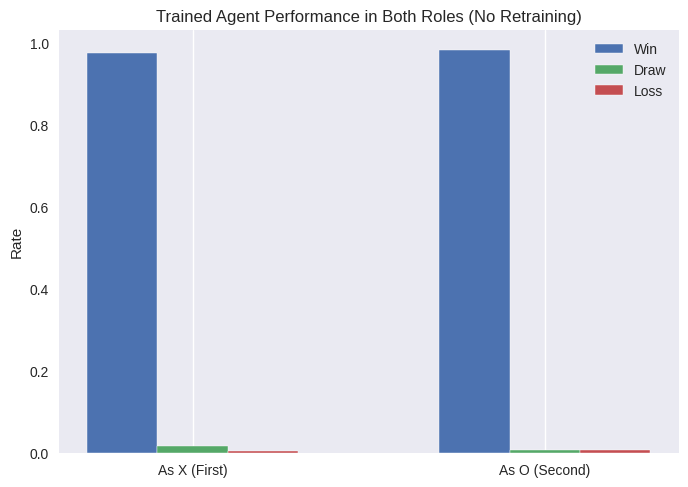

In [17]:
roles = ['As X (First)', 'As O (Second)']
win_rates = [win_x, win_o]
draw_rates = [draw_x, draw_o]
loss_rates = [loss_x, loss_o]

x = np.arange(len(roles))
plt.bar(x - 0.2, win_rates, 0.2, label='Win')
plt.bar(x, draw_rates, 0.2, label='Draw')
plt.bar(x + 0.2, loss_rates, 0.2, label='Loss')
plt.xticks(x, roles)
plt.ylabel('Rate')
plt.title('Trained Agent Performance in Both Roles (No Retraining)')
plt.legend()
plt.grid(axis='y')
plt.show()

Interestingly, although the model was trained only to play by making the first move, it was still able to maintain comparable performance when made to play from the second move

-----

## Play against it